In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy.io import fits
import os
import sys
import pdb
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from photutils.isophote import Ellipse
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

In [3]:
def correcting_image(filename, flag_img_or_msk):
    hdu = fits.open(filename)
    img_to_correct = hdu[0].data
    hdr_to_correct = hdu[0].header
    if   flag_img_or_msk == "img":
        img_to_correct[np.isnan(img_to_correct) == True] = 0
    elif flag_img_or_msk == "msk":
        img_to_correct[np.isnan(img_to_correct) == True] = 1
        
    fits.writeto(filename, img_to_correct, overwrite=True)

In [4]:
fits_files = ["17058_goodss_B_hudf.fits","17058_goodss_V_hudf.fits","17058_goodss_I_hudf.fits",
              "17058_goodss_Y_hudf.fits","17058_goodss_J_hudf.fits","17058_goodss_H_hudf.fits"]
zp = [25.673, 26.486, 25.654, 26.269, 26.230, 25.946]
pix_scale = [0.03, 0.03, 0.03, 0.06, 0.06, 0.03]
max_sb = [18, 18, 18, 18, 18, 18]
min_sb = [32, 32, 32, 32, 32, 32]
semimajor_axis = 60
position_angle = 90
axis_ratio = 0.7; ellip = 1 - axis_ratio
flag_check_images = False

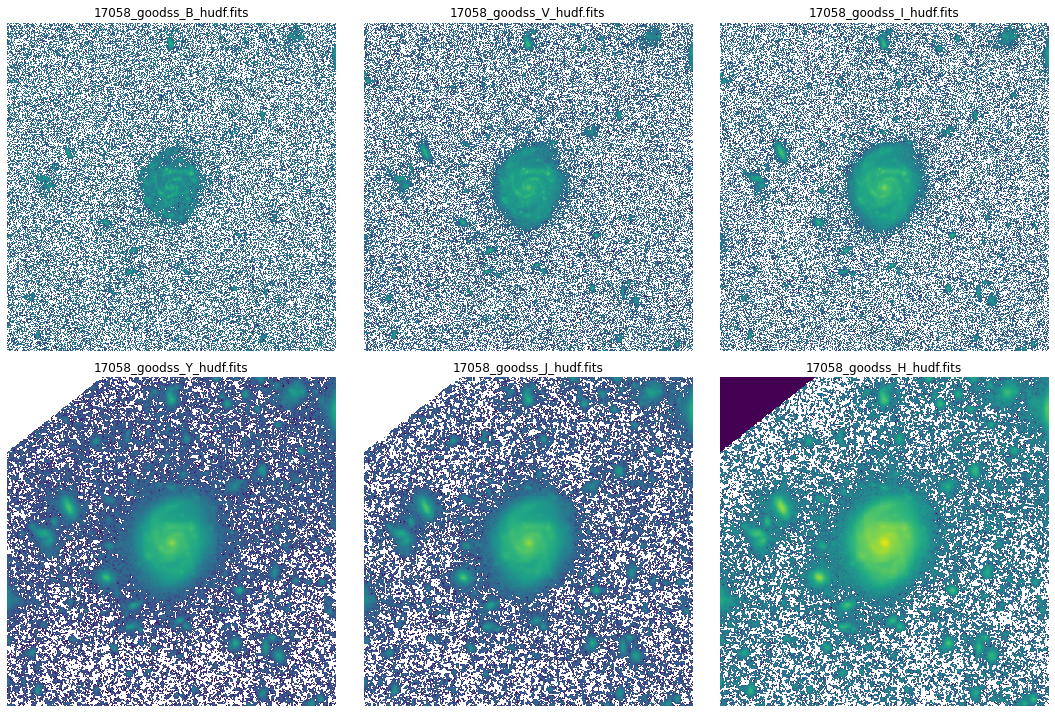

In [5]:
# Create 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop over FITS files and display with imshow
for ii, (ax, filename) in enumerate(zip(axes, fits_files)):
    with fits.open(filename) as hdu:
        img = hdu[0].data
        hdr = hdu[0].header

    img[img <= 0] = float("NaN")

    sb_img = -2.5*np.log10(img)+zp[ii]+(5*np.log10(pix_scale[ii]))
    if ii == 0 and flag_check_images == True: fits.writeto("test_B.fits", sb_img, hdr, overwrite=True)
                                         
    # Show image (auto contrast scaling with vmin/vmax as needed)
    img = ax.imshow(sb_img, cmap='viridis_r', origin='lower', vmin=max_sb[ii], vmax=min_sb[ii], interpolation="none")
    ax.set_title(f"{filename}")
    ax.axis('off')

# Adjust layout and show colorbar
plt.tight_layout()
plt.show()

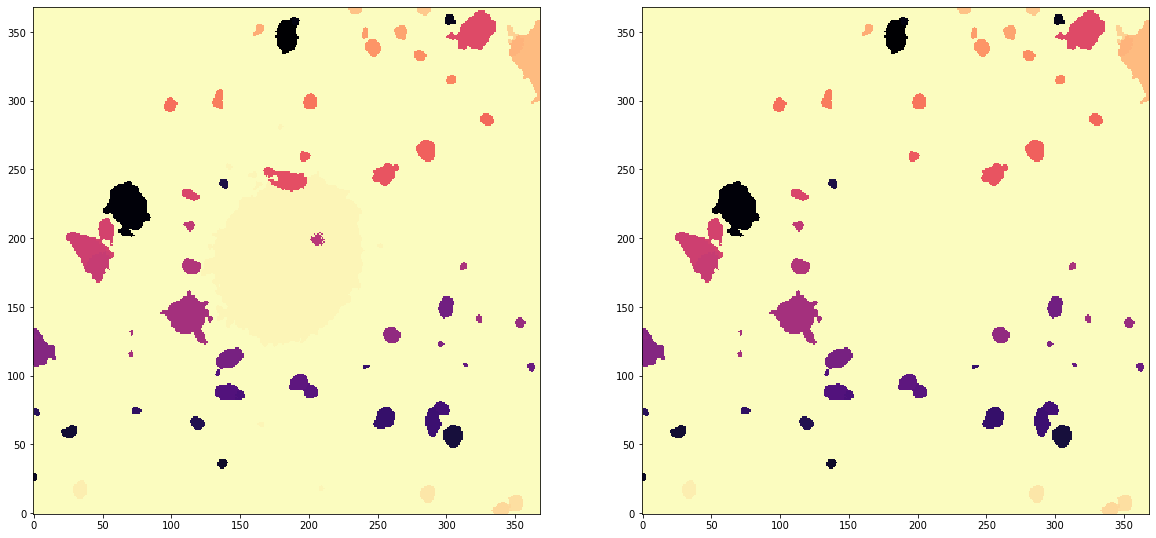

In [6]:
hdu = fits.open("segmentation_H.fits")
msk = hdu[0].data
hdr = hdu[0].header

all_masked = np.copy(msk)

msk[msk == 1]  = 0 #to make the pixel belonging to this detection background pixels
msk[msk == 24] = 0 #to make the pixel belonging to this detection background pixels
msk[msk == 31] = 0 #to make the pixel belonging to this detection background pixels

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(all_masked, origin = "lower", interpolation ="none", cmap = "magma_r")
ax2.imshow(msk,        origin = "lower", interpolation ="none", cmap = "magma_r")

msk_zeros  = msk == 0
msk_others = msk != 0
msk[msk_others] = 1 #value for masking neighbouring objects in GALFIT
fits.writeto("mask_H_for_galfit.fits", msk, hdr, overwrite=True)

msk_for_profiles = np.copy(msk)
msk_for_profiles_zeros = msk_for_profiles == 0
msk_for_profiles_ones  = msk_for_profiles == 1
msk_for_profiles[msk_for_profiles_zeros] = 1
msk_for_profiles[msk_for_profiles_ones]  = 0 #value for masking neighbouring objects in gnuastro's astscript-radial-profiles
fits.writeto("mask_H_for_profiles.fits", msk_for_profiles, hdr, overwrite=True)

In [7]:
"""
checking GALFIT inputs
"""

hdu = fits.open("17058_goodss_H_hudf.fits")
checking_image = np.isnan(hdu[0].data).any()
if checking_image == True: correcting_image("17058_goodss_H_hudf.fits", "img")

hdu = fits.open("mask_H_for_galfit.fits")
checking_image = np.isnan(hdu[0].data).any()
if checking_image == True: correcting_image("mask_H_for_galfit.fits", "msk")

/tmp/ipykernel_3686833/4204613875.py:10: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(img)*msk, origin='lower', interpolation="none", vmin=-4)


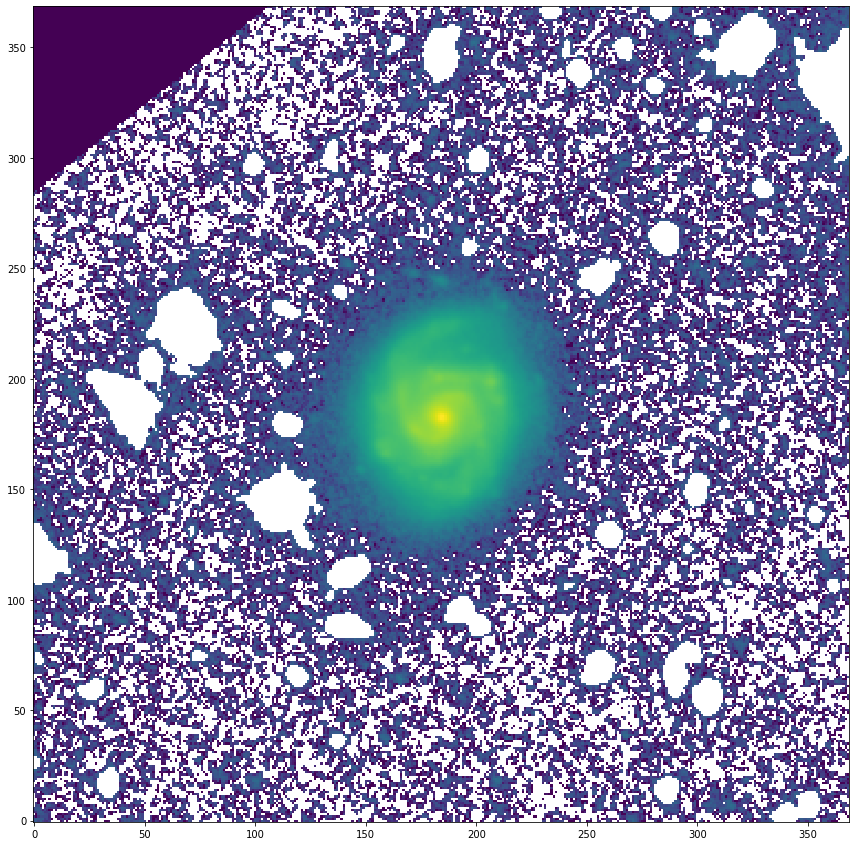

In [8]:
hdu = fits.open(fits_files[-1])
img = hdu[0].data
hdr = hdu[0].header

msk = msk.astype(float)
msk[msk_zeros]  = 1
msk[msk_others] = float("NaN")

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(np.log10(img)*msk, origin='lower', interpolation="none", vmin=-4)

In [9]:
x_cen = hdr["NAXIS1"]/2.
y_cen = hdr["NAXIS2"]/2.

geometry = EllipseGeometry(x0=x_cen, y0=y_cen, sma=semimajor_axis, eps=ellip, pa=position_angle * np.pi / 180.)
print(geometry.find_center(img),geometry.x0,geometry.y0)

INFO: Found center at x0 = 185.0, y0 = 183.0 [photutils.isophote.geometry]
None 185.0 183.0


/tmp/ipykernel_3686833/4082978910.py:5: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(img), origin='lower', interpolation="none", vmin=-4)


(<matplotlib.patches.Ellipse at 0x7e1a2b8de550>,)

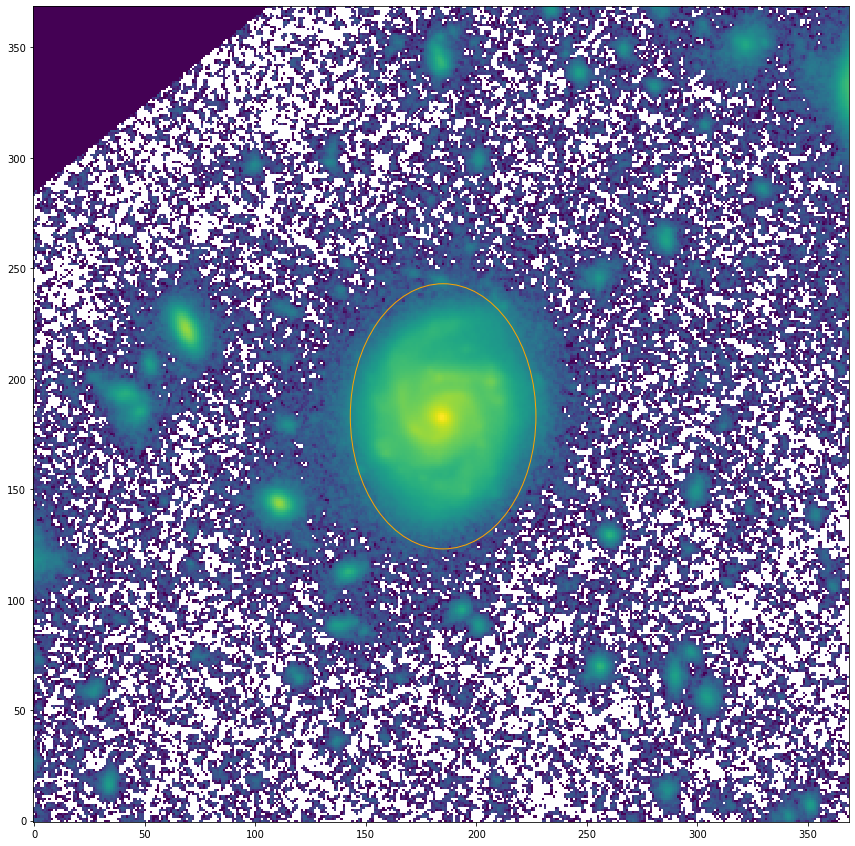

In [10]:
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                          geometry.sma * (1 - geometry.eps),
                          geometry.pa)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(np.log10(img), origin='lower', interpolation="none", vmin=-4)
aper.plot(color='orange')

In [11]:
msk = msk.astype(bool)
img = np.ma.array(img,mask=~msk)
ellipse = Ellipse(img, geometry)

In [12]:
isolist = ellipse.fit_image()

Text(0, 0.5, 'y0')

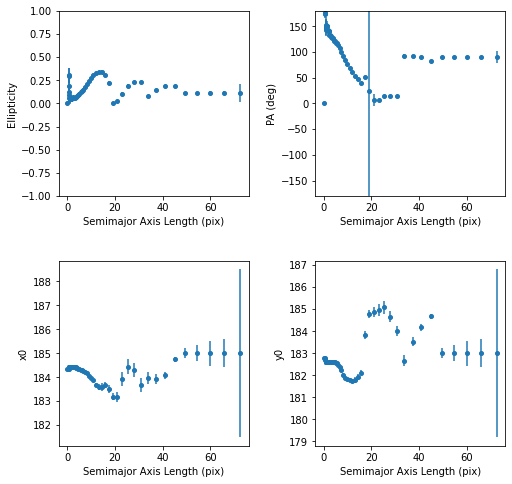

In [13]:
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.35, wspace=0.35)

plt.subplot(2, 2, 1)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
             fmt='o', markersize=4)
plt.ylim(-1,1)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('Ellipticity')

plt.subplot(2, 2, 2)
plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.,
             yerr=isolist.pa_err / np.pi * 80., fmt='o', markersize=4)
plt.ylim(-180,180)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('PA (deg)')

plt.subplot(2, 2, 3)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
             markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('x0')

plt.subplot(2, 2, 4)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
             markersize=4)
plt.xlabel('Semimajor Axis Length (pix)')
plt.ylabel('y0')

In [14]:
fig, (ax1, ax2) = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(np.log10(img)*msk, origin='lower', interpolation="none", vmin=-4)

smas = np.linspace(10, 100, 15)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='orange')

ax2.imshow(np.log10(img), origin='lower', interpolation="none", vmin=-4)

/tmp/ipykernel_3686833/972076271.py:3: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(img)*msk, origin='lower', interpolation="none", vmin=-4)
/tmp/ipykernel_3686833/972076271.py:11: RuntimeWarning: invalid value encountered in log10
  ax2.imshow(np.log10(img), origin='lower', interpolation="none", vmin=-4)
